# Preliminaries

In [1]:
#import libraries
import pandas as pd
print('pandas: %s' % pd.__version__)

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 150)

import numpy as np
print('geopandas: %s' % np.__version__)

# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

import decimal
from decimal import Decimal

import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dropout,BatchNormalization,Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from keras import callbacks
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,MaxPooling2D # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

from pathlib import Path  

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import plot_model


pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2


In [2]:
import sys
sys.path.append("/Users/paolo/Documents/TC/Paolo/scripts/")
from aux import extract_cyclones, extract_target, find_neighbour
radius=2.5
train_path='/Users/paolo/Documents/TC/data/training_real_tom_target.csv'
val_path='/Users/paolo/Documents/TC/data/validation_real_tom_target.csv'
test_path='/Users/paolo/Documents/TC/data/test_real_tom_target.csv'


pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2


# full features, standardized

In [3]:
test = pd.read_csv('/Users/paolo/Documents/TC/data/test_real_tom_target.csv').drop(columns=['Unnamed: 0'])
train = pd.read_csv('/Users/paolo/Documents/TC/data/training_real_tom_target.csv').drop(columns=['Unnamed: 0'])
val = pd.read_csv('/Users/paolo/Documents/TC/data/validation_real_tom_target.csv').drop(columns=['Unnamed: 0'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols_to_std = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
train_std,val_std,test_std = train,val,test

# apply standardization on numerical features
train_std[cols_to_std] = scaler.fit_transform(train[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']])
val_std[cols_to_std] = scaler.transform(val[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']])
test_std[cols_to_std] = scaler.transform(test[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']])


# Single point of features

In [4]:
train_cyclones, val_cyclones, test_cyclones = extract_cyclones()


/Users/paolo/Documents/TC/Paolo/scripts/aux.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key']=df.apply(lambda x: [x.latitude,x.longitude,x.time], axis=1)
/Users/paolo/Documents/TC/Paolo/scripts/aux.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key']=df.apply(lambda x: [x.latitude,x.longitude,x.time], axis=1)
/Users/paolo/Documents/TC/Paolo/scripts/aux.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [5]:
print(len(train_cyclones))

1635


In [6]:
train_zero_samples = train_std.loc[train_std.Real_tom_lsm==0].sample(len(train_cyclones))

In [7]:
train_one_samples = train_std.loc[train_std.apply(lambda x: [x.latitude,x.longitude,x.time] in train_cyclones, axis=1)]


In [8]:
train_balanced_samples = pd.concat((train_zero_samples.reset_index(),train_one_samples.reset_index()),axis=0).reset_index()


# Models

## Data preparation

In [14]:
features_list = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
x_train = train_balanced_samples[features_list]
x_val = val_std[features_list]
x_test = test_std[features_list]
y_train = train_balanced_samples.Real_tom_lsm
y_val = val_std.Real_tom_lsm
y_test = test_std.Real_tom_lsm

## FFNN, 1L, 8N

In [15]:
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid')) # Output
model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

model.summary()



Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


2023-01-18 15:10:29.090602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 15:10:29.092557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.fit(x_train,y_train,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=100)


Epoch 1/100


2023-01-18 15:10:31.622232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-18 15:10:31.922395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.6154

2023-01-18 15:10:33.579270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 45s 429ms/step - loss: 0.6154 - val_loss: 0.5223
Epoch 2/100
103/103 [==============================] - 45s 440ms/step - loss: 0.5273 - val_loss: 0.4799
Epoch 3/100
103/103 [==============================] - 44s 435ms/step - loss: 0.4934 - val_loss: 0.4195
Epoch 4/100
103/103 [==============================] - 44s 432ms/step - loss: 0.4709 - val_loss: 0.3785
Epoch 5/100
103/103 [==============================] - 44s 432ms/step - loss: 0.4306 - val_loss: 0.3590
Epoch 6/100
103/103 [==============================] - 44s 431ms/step - loss: 0.4299 - val_loss: 0.3421
Epoch 7/100
103/103 [==============================] - 44s 436ms/step - loss: 0.4194 - val_loss: 0.3243
Epoch 8/100
103/103 [==============================] - 46s 446ms/step - loss: 0.4117 - val_loss: 0.3179
Epoch 9/100
103/103 [==============================] - 44s 431ms/step - loss: 0.4044 - val_loss: 0.3142
Epoch 10/100
103/103 [==============================] - 44s 430ms/step - los

16859/16859 [==============================] - 20s 1ms/step


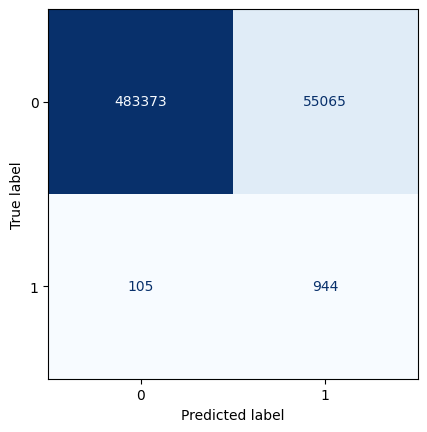

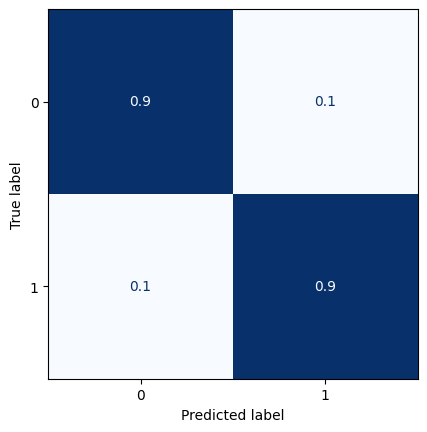

In [19]:
t = model.predict(x_test)

classes = []
for i in t.reshape(-1,1):
    if i<=0.5: classes.append(0)
    else: classes.append(1)

# confusion matrix with threshold on 0.5 
ConfusionMatrixDisplay(confusion_matrix(y_test, classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
ConfusionMatrixDisplay(confusion_matrix(y_test, classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)


## FFNN, 1L, 64N

In [20]:
model_1_64 = Sequential()
model_1_64.add(Dense(64, input_dim=8, activation='relu'))
model_1_64.add(Dropout(0.5))
model_1_64.add(Dense(1,activation='sigmoid')) # Output
model_1_64.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

model_1_64.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                576       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_1_64.fit(x_train,y_train,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=100)


Epoch 1/100


2023-01-18 17:36:47.568656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.6087

2023-01-18 17:36:48.611538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 45s 436ms/step - loss: 0.6087 - val_loss: 0.5484
Epoch 2/100
103/103 [==============================] - 44s 433ms/step - loss: 0.3900 - val_loss: 0.3996
Epoch 3/100
103/103 [==============================] - 44s 434ms/step - loss: 0.3281 - val_loss: 0.3317
Epoch 4/100
103/103 [==============================] - 44s 435ms/step - loss: 0.2933 - val_loss: 0.2990
Epoch 5/100
103/103 [==============================] - 45s 439ms/step - loss: 0.2904 - val_loss: 0.2840
Epoch 6/100
103/103 [==============================] - 45s 436ms/step - loss: 0.2728 - val_loss: 0.2662
Epoch 7/100
103/103 [==============================] - 45s 439ms/step - loss: 0.2676 - val_loss: 0.2727
Epoch 8/100
103/103 [==============================] - 45s 440ms/step - loss: 0.2618 - val_loss: 0.2736
Epoch 9/100
103/103 [==============================] - 45s 444ms/step - loss: 0.2582 - val_loss: 0.2700
Epoch 10/100
103/103 [==============================] - 45s 444ms/step - los

   61/16859 [..............................] - ETA: 28s 

2023-01-18 18:18:17.650014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16859/16859 [==============================] - 21s 1ms/step


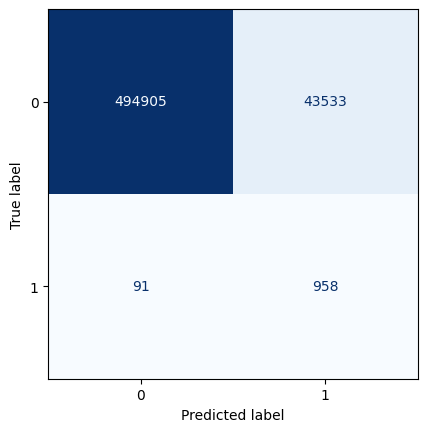

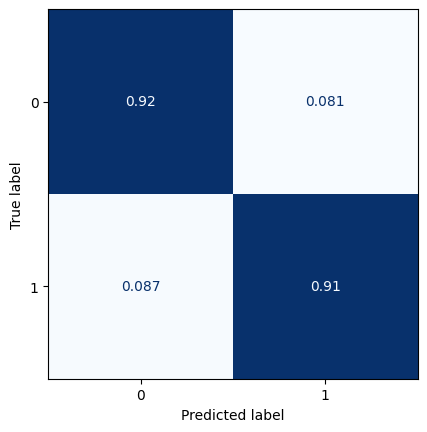

In [24]:
t = model_1_64.predict(x_test)

classes = []
for i in t.reshape(-1,1):
    if i<=0.5: classes.append(0)
    else: classes.append(1)

# confusion matrix with threshold on 0.5 
ConfusionMatrixDisplay(confusion_matrix(y_test, classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
ConfusionMatrixDisplay(confusion_matrix(y_test, classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)


## FFNN, 2L, 16N

In [28]:
model_2_16 = Sequential()
model_2_16.add(Dense(16, input_dim=8, activation='relu'))
model_2_16.add(Dropout(0.5))
model_2_16.add(Dense(16, input_dim=8, activation='relu'))
model_2_16.add(Dropout(0.5))
model_2_16.add(Dense(1,activation='sigmoid')) # Output
model_2_16.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

model_2_16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_2_16.fit(x_train,y_train,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=100)


Epoch 1/100


2023-01-19 09:38:36.169351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.7117

2023-01-19 09:38:37.312419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 48s 466ms/step - loss: 0.7117 - val_loss: 0.5464
Epoch 2/100
103/103 [==============================] - 48s 472ms/step - loss: 0.5922 - val_loss: 0.4857
Epoch 3/100
103/103 [==============================] - 48s 475ms/step - loss: 0.4993 - val_loss: 0.4302
Epoch 4/100
103/103 [==============================] - 46s 453ms/step - loss: 0.4394 - val_loss: 0.3844
Epoch 5/100
103/103 [==============================] - 46s 452ms/step - loss: 0.4007 - val_loss: 0.3502
Epoch 6/100
103/103 [==============================] - 48s 466ms/step - loss: 0.3857 - val_loss: 0.3348
Epoch 7/100
103/103 [==============================] - 47s 457ms/step - loss: 0.3733 - val_loss: 0.3108
Epoch 8/100
103/103 [==============================] - 47s 461ms/step - loss: 0.3621 - val_loss: 0.2993
Epoch 9/100
103/103 [==============================] - 47s 462ms/step - loss: 0.3512 - val_loss: 0.2756
Epoch 10/100
103/103 [==============================] - 47s 457ms/step - los

   67/16859 [..............................] - ETA: 25s 

2023-01-19 10:25:31.083528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16859/16859 [==============================] - 22s 1ms/step


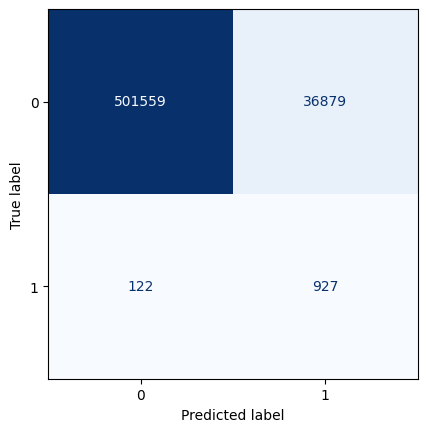

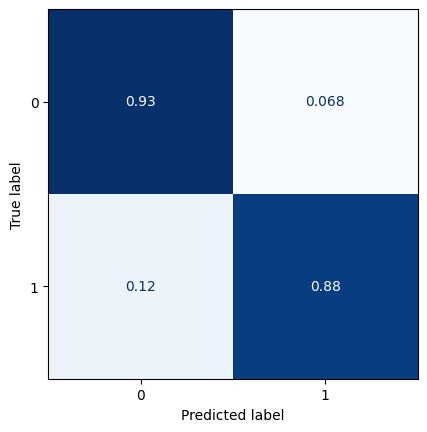

In [30]:
t = model_2_16.predict(x_test)

classes = []
for i in t.reshape(-1,1):
    if i<=0.5: classes.append(0)
    else: classes.append(1)

# confusion matrix with threshold on 0.5 
ConfusionMatrixDisplay(confusion_matrix(y_test, classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
ConfusionMatrixDisplay(confusion_matrix(y_test, classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)


## FFNN, 3L, 8-16-32N

In [32]:
model_3_81632 = Sequential()
model_3_81632.add(Dense(8, input_dim=8, activation='relu'))
model_3_81632.add(Dropout(0.5))
model_3_81632.add(Dense(16, input_dim=8, activation='relu'))
model_3_81632.add(Dropout(0.5))
model_3_81632.add(Dense(32, input_dim=8, activation='relu'))
model_3_81632.add(Dropout(0.5))
model_3_81632.add(Dense(1,activation='sigmoid')) # Output
model_3_81632.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

model_3_81632.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 16)                144       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [33]:
model_3_81632.fit(x_train,y_train,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=100)


Epoch 1/100


2023-01-19 10:39:10.149005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.6602

2023-01-19 10:39:11.528613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 50s 481ms/step - loss: 0.6602 - val_loss: 0.6849
Epoch 2/100
103/103 [==============================] - 49s 483ms/step - loss: 0.5581 - val_loss: 0.5937
Epoch 3/100
103/103 [==============================] - 49s 484ms/step - loss: 0.4910 - val_loss: 0.4988
Epoch 4/100
103/103 [==============================] - 49s 484ms/step - loss: 0.4594 - val_loss: 0.4027
Epoch 5/100
103/103 [==============================] - 50s 493ms/step - loss: 0.4273 - val_loss: 0.3417
Epoch 6/100
103/103 [==============================] - 49s 475ms/step - loss: 0.4131 - val_loss: 0.3074
Epoch 7/100
103/103 [==============================] - 49s 480ms/step - loss: 0.3892 - val_loss: 0.2803
Epoch 8/100
103/103 [==============================] - 50s 488ms/step - loss: 0.3725 - val_loss: 0.2579
Epoch 9/100
103/103 [==============================] - 48s 475ms/step - loss: 0.3623 - val_loss: 0.2402
Epoch 10/100
103/103 [==============================] - 49s 479ms/step - los

2023-01-19 12:00:24.106703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16859/16859 [==============================] - 24s 1ms/step


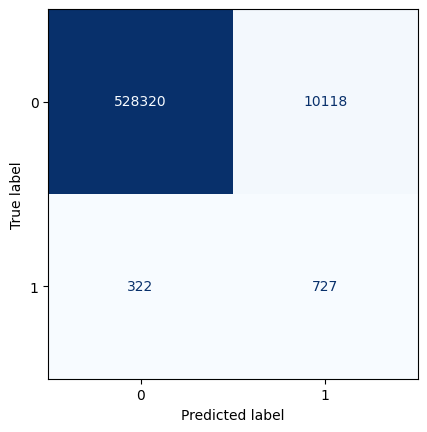

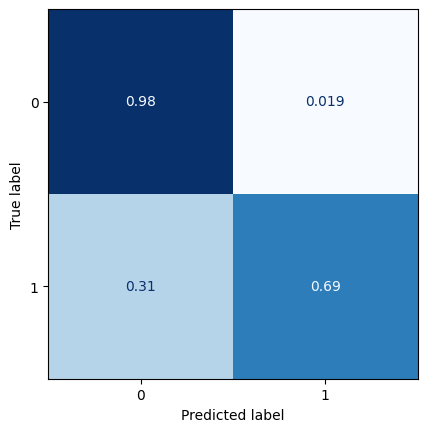

In [34]:
t = model_3_81632.predict(x_test)

classes = []
for i in t.reshape(-1,1):
    if i<=0.5: classes.append(0)
    else: classes.append(1)

# confusion matrix with threshold on 0.5 
ConfusionMatrixDisplay(confusion_matrix(y_test, classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
ConfusionMatrixDisplay(confusion_matrix(y_test, classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)


## FFNN, 3L, 8-16-32-64N

In [37]:
model_4_8163264 = Sequential()
model_4_8163264.add(Dense(8, input_dim=8, activation='relu'))
model_4_8163264.add(Dropout(0.5))
model_4_8163264.add(Dense(16, input_dim=8, activation='relu'))
model_4_8163264.add(Dropout(0.5))
model_4_8163264.add(Dense(32, input_dim=8, activation='relu'))
model_4_8163264.add(Dropout(0.5))
model_4_8163264.add(Dense(64, input_dim=8, activation='relu'))
model_4_8163264.add(Dropout(0.5))
model_4_8163264.add(Dense(1,activation='sigmoid')) # Output
model_4_8163264.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

model_4_8163264.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 8)                 72        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_22 (Dense)            (None, 16)                144       
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 32)                544       
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 64)               

In [38]:
model_4_8163264.fit(x_train,y_train,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=100)


Epoch 1/100


2023-01-19 13:28:36.338400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.6624

2023-01-19 13:28:37.545401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 52s 502ms/step - loss: 0.6624 - val_loss: 0.6183
Epoch 2/100
103/103 [==============================] - 52s 508ms/step - loss: 0.5877 - val_loss: 0.5306
Epoch 3/100
103/103 [==============================] - 53s 516ms/step - loss: 0.5384 - val_loss: 0.4510
Epoch 4/100
103/103 [==============================] - 52s 510ms/step - loss: 0.4823 - val_loss: 0.3499
Epoch 5/100
103/103 [==============================] - 52s 512ms/step - loss: 0.4432 - val_loss: 0.3022
Epoch 6/100
103/103 [==============================] - 52s 507ms/step - loss: 0.4142 - val_loss: 0.2613
Epoch 7/100
103/103 [==============================] - 51s 498ms/step - loss: 0.3947 - val_loss: 0.2369
Epoch 8/100
103/103 [==============================] - 52s 509ms/step - loss: 0.3777 - val_loss: 0.2052
Epoch 9/100
103/103 [==============================] - 54s 528ms/step - loss: 0.3580 - val_loss: 0.2173
Epoch 10/100
103/103 [==============================] - 52s 507ms/step - los

   42/16859 [..............................] - ETA: 42s 

2023-01-19 15:20:31.084630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16859/16859 [==============================] - 30s 2ms/step


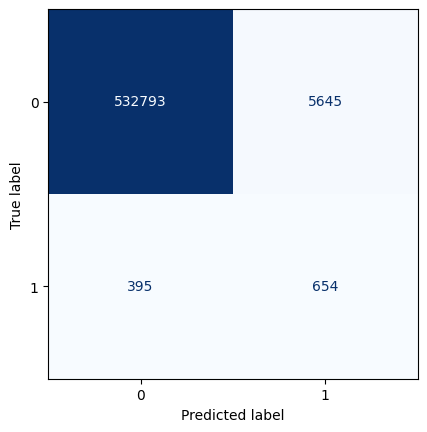

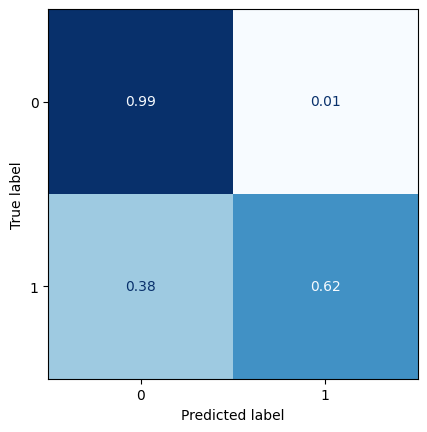

In [39]:
t = model_4_8163264.predict(x_test)

classes = []
for i in t.reshape(-1,1):
    if i<=0.5: classes.append(0)
    else: classes.append(1)

# confusion matrix with threshold on 0.5 
ConfusionMatrixDisplay(confusion_matrix(y_test, classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
ConfusionMatrixDisplay(confusion_matrix(y_test, classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
